In [1]:
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Activation, Flatten, Dense, Dropout
from keras.callbacks import Callback, EarlyStopping, TensorBoard, ModelCheckpoint

from google.colab import files
import zipfile,os

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(context="talk")

# Import File

In [2]:
local_zip = '/content/drive/MyDrive/archive_6.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/')
zip_ref.close()

In [3]:
base_dir = ('/rps-cv-images')
os.listdir(base_dir)

['paper', 'scissors', 'rock', 'README_rpc-cv-images.txt']

# Buat Data Generator dan Split Data

In [33]:
train_datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 20,
    horizontal_flip = True,
    shear_range = 0.2,
    fill_mode = 'nearest',
    validation_split = 0.2 
)

validation_datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 20,
    horizontal_flip = True,
    shear_range = 0.2,
    fill_mode = 'nearest',
    validation_split = 0.2
)

# Membuat data train dan data validation

In [34]:
# Buat generator untuk train
train_generator = train_datagen.flow_from_directory(
    base_dir,
    target_size=(150, 150),
    batch_size=64,
    class_mode='categorical',
    subset='training'
    )
 
 # Buat generator untuk validation
validation_generator = validation_datagen.flow_from_directory(
    base_dir,
    target_size=(150, 150),
    batch_size=64,
    class_mode='categorical',
    subset='validation'
    )

Found 1751 images belonging to 3 classes.
Found 437 images belonging to 3 classes.


# Buat Arsitektur Model

In [47]:
model = Sequential([
                    Conv2D(128, (3,3), activation='relu', input_shape=(150, 150, 3)),
                    MaxPooling2D(2, 2),
                    Conv2D(256, (3,3), activation='relu'),
                    MaxPooling2D(2,2),
                    Flatten(),
                    Dense(128, activation='relu'),
                    Dropout(0.2),
                    Dense(64, activation='relu'),
                    Dense(3, activation='softmax')
])

# Compile

In [48]:
opt = Adam(learning_rate=0.00035) # Set optimizer dan learning rate
model.compile(optimizer = opt, loss = 'categorical_crossentropy', metrics = ['accuracy']) 

# Training

In [49]:
# buat variabel untuk menampung early stopping pada callback
es = EarlyStopping(monitor='val_accuracy', mode="max", patience=2, verbose=1, restore_best_weights=True)

In [50]:
hist = model.fit(
    train_generator,
    steps_per_epoch = 64,
    epochs = 5,
    validation_data = validation_generator,
    validation_steps = 32,
    verbose = 1,
    callbacks = [es],
    workers=2
)

Epoch 1/5
64/64 [==============================] - 44s 646ms/step - loss: 1.1096 - accuracy: 0.4572 - val_loss: 0.5865 - val_accuracy: 0.8019
Epoch 2/5
64/64 [==============================] - 39s 610ms/step - loss: 0.5002 - accuracy: 0.8148 - val_loss: 0.2923 - val_accuracy: 0.8977
Epoch 3/5
64/64 [==============================] - 40s 629ms/step - loss: 0.2384 - accuracy: 0.9281 - val_loss: 0.2090 - val_accuracy: 0.9256
Epoch 4/5
64/64 [==============================] - 40s 640ms/step - loss: 0.1405 - accuracy: 0.9599 - val_loss: 0.1446 - val_accuracy: 0.9463
Epoch 5/5
64/64 [==============================] - 45s 708ms/step - loss: 0.1214 - accuracy: 0.9600 - val_loss: 0.1307 - val_accuracy: 0.9548


# Akurasi Model
Akurasi Model terhapap data training

In [52]:
model.evaluate(train_generator, workers=2, steps=64, verbose=1)

64/64 [==============================] - 24s 386ms/step - loss: 0.0717 - accuracy: 0.9766


[0.07166702300310135, 0.9765920042991638]

Akurasi Model terhadap data testing / validation

In [53]:
model.evaluate(validation_generator, steps=32, verbose=1, workers=2)

32/32 [==============================] - 12s 397ms/step - loss: 0.1294 - accuracy: 0.9568


[0.12940317392349243, 0.9568489789962769]

# Plotting

<function matplotlib.pyplot.plot>

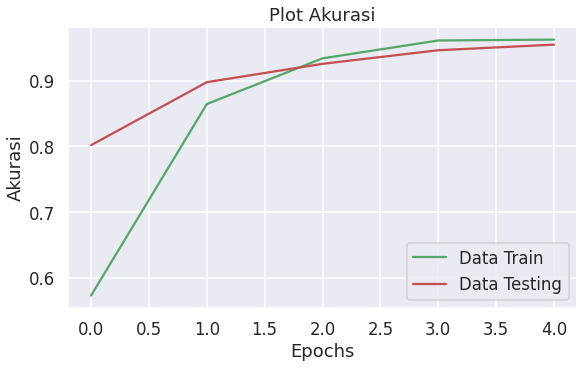

In [59]:
fig, ax = plt.subplots(constrained_layout=True, figsize=(8, 5))
_ = ax.set_title("Plot Akurasi")
_ = plt.plot(hist.history["accuracy"], color="g", label="Data Train")
_ = plt.plot(hist.history["val_accuracy"], color="r", label="Data Testing")
_ = ax.set_xlabel("Epochs")
_ = ax.set_ylabel("Akurasi")
_ = ax.legend()

plt.plot

<function matplotlib.pyplot.plot>

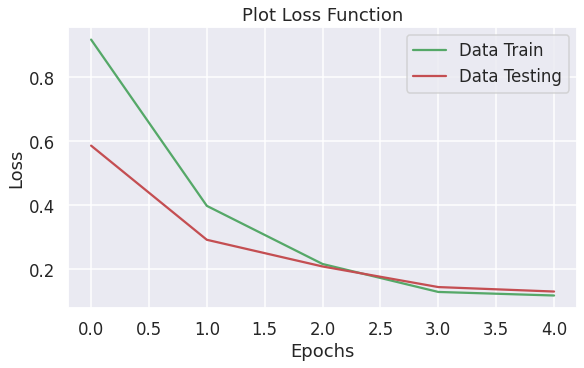

In [60]:
fig, ax = plt.subplots(constrained_layout=True, figsize=(8, 5))
_ = ax.set_title("Plot Loss Function")
_ = plt.plot(hist.history["loss"], color="g", label="Data Train")
_ = plt.plot(hist.history["val_loss"], color="r", label="Data Testing")
_ = ax.set_xlabel("Epochs")
_ = ax.set_ylabel("Loss")
_ = ax.legend()

plt.plot

# Save ke TFLite

In [61]:
convert = tf.lite.TFLiteConverter.from_keras_model(model)
model_lite = convert.convert()
with tf.io.gfile.GFile('model.tflite', 'wb') as f:
  f.write(model_lite)

INFO:tensorflow:Assets written to: /tmp/tmpjaxiet0a/assets
